# L'ANALYSE DE SENTIMENT

Le sujet de ce notebook est l'analyse de sentiment de tweets, c’est-à-dire pouvoir automatiser la classification de tweet dans les labels positif, négatif ou neutre. Ce genre de classification peut être utile pour connaitre les tendances par rapport à un produit, une marque, une personne, ...

Pour ceci nous allons utiliser des classifieurs intégrés nltk et sklearn ainsi que le dataset construit dans le notebook dataset.

Les classifieurs les plus courants en NLP sont le classifieur bayésien naïf l'arbre de décision et les réseaux de neuronne, nous allons étudier ces 3-là et la SVC.

 ## Les Imports

In [ ]:
import matplotlib.pyplot as plt
import re, string, random
import numpy as np


import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import NaiveBayesClassifier,DecisionTreeClassifier #classifieur naif bayes et arbre de decision de  nltk
from nltk.classify import SklearnClassifier #fontion qui permet d'utiliser les classifieurs de scikit

from sklearn import metrics 
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

### Le Dataset

Pour le detail de ce qui est ci-dessous et explication de l'élaboration du dataset cf.  le notebook dataset.ipynb

In [ ]:
stop_words = stopwords.words('english')

positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')
neutral_tweet_tokens = np.random.choice(twitter_samples.tokenized('tweets.20150430-223406.json'),size=len(negative_tweet_tokens),replace = False)

def remove_noise(tweet_tokens, stop_words = ()): 

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens


def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

def make_set( tweet_tokens, label="", stop_words = () ) :
    cleaned_tokens_list = []
    for tokens in tweet_tokens:
        cleaned_tokens_list.append(remove_noise(tokens, stop_words))

    tokens_for_model = get_tweets_for_model(cleaned_tokens_list)
    dataset = [(tweet_dict, label)for tweet_dict in tokens_for_model]
    return dataset


positive_dataset = make_set( positive_tweet_tokens, label="Positive", stop_words = stop_words )
negative_dataset = make_set( negative_tweet_tokens, label="Negative", stop_words = stop_words )
neutral_dataset = make_set( neutral_tweet_tokens, label="Neutral", stop_words = stop_words )

dataset = positive_dataset + negative_dataset + neutral_dataset
random.shuffle(dataset)

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Naive bayes classifieur

En premier lieu nous allons utiliser le classifieur de bayes naïf.Ce dernier nous estime pour chaque tweet une probabilité d'être positif négatif au neutre, le label choisi sera celui de plus grandes probabilités.

* Ce classifieur est dit de Bayes car utilise la formule de Bayes:$ P(C\vert F _{1},\dots ,F_{n})={\frac  {P(C)\ P(F_{1},\dots ,F_{n}\vert C)}{P(F _{1},\dots ,F_{n})}} $ Ici $C$ correspond à la classe et peut prendre la valeur "positif", "négatif" ou "neutre" et $F_i$ correspond au i-ème mot de notre dictionnaire et prend la valeur $0$ si absent du tweet ou $1$ sinon.
* Ce classifieur est dit naïf, c’est-à-dire que nous supposons que l'apparition d'un mot dans une phrase est indépendante des autres mots.


-Ainsi grace à l'hypothèse d'indépendance et à la définition de la probabilité conditionnelle on obtient pour le second terme du numérateur de la formule Bayes (ce terme est la vraisemblance) :

$P(F_{1},\dots ,F_{n}\vert C)$

$=P(F_{1}\vert C)\  \cdots \ P(F_{n}\vert C)$

$=\prod _{{i=1}}^{n}P(F_{i}\vert C)$

Que l'on estime à l'apprentissage du modèle grâce à;

${ \widehat {P(F_{i}\vert C)}  = {\frac {nombre\_de\_tweet\_en\_classe\_C\_avec\_F_i}{nombre\_de\_tweet\_en\_classe\_C}} }$

-Ensuite pour le terme au dénominateur grace aussi à l'hypothèse d'indépendance on a :

${P(F_{1},\dots ,F_{n})} = {P(F_{1})\dots P(F_{n})} $

et on estime grace à (en réalité jamais calculée car quelle que soit la classe, l'évidence (ce terme) est inchangé, ce n'est qu'un coefficient de proportionnalité; 

$ \widehat { P(F_{i})} = {\frac {nombre\_de\_tweet\_avec\_F_i}{nombre\_de\_tweet} } $

-Pour finir le premier terme du numérateur est estimé par ;

$ \widehat{P(C)} = {\frac {nombre\_de\_tweet\_de\_classe\_C}{nombre\_de\_tweet} }$


###Evolution des performance du classifieur en fonction de la taille du Trainset 

A partir d'ici certaines mesures vont être utilisées voici leurs definitions:

* la precision : $\frac{true\_positive}{true\_positive+false\_positive}$
* le recall : $\frac{true\_positive}{true\_positive+false\_negative}$
* le F1-score : $\frac{2}{precision^{-1}+recall^{-1}}$

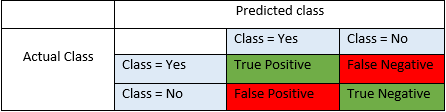

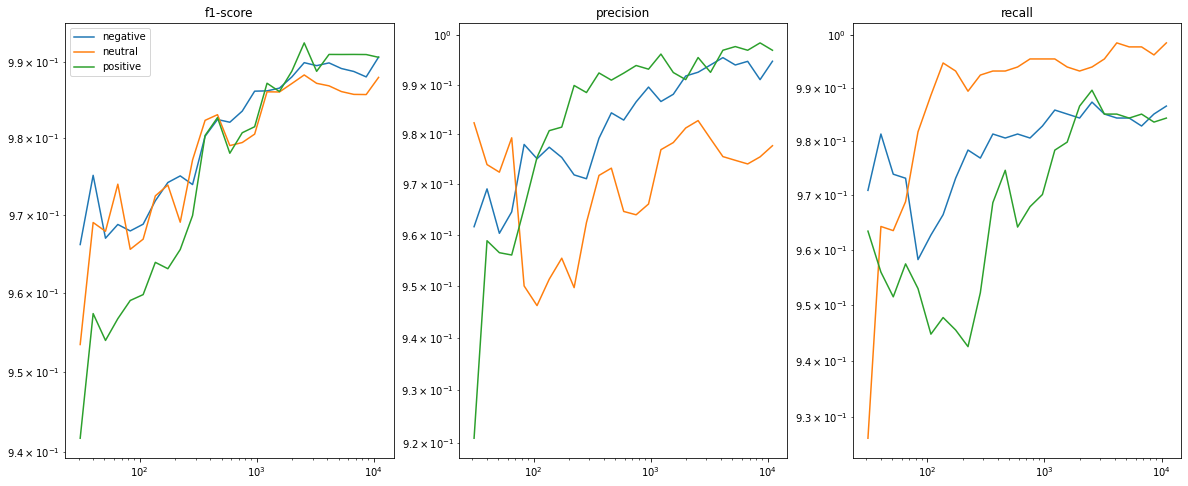

In [ ]:
F0=[]
P0=[]
R0=[]

F1=[]
P1=[]
R1=[]

F2=[]
P2=[]
R2=[]

test_data = dataset[11000:]
x_test=[]
y_test=[]
for a in test_data :
    x_test.append(a[0])
    y_test.append(a[1])

K = np.int_(10**np.linspace(1.5,np.log10(11000-1),25))
for k in K :
    train_data = dataset[:k]
    
    clf_sentiment = NaiveBayesClassifier.train(train_data)
    
    y_pred = clf_sentiment.classify_many(x_test)

    d = metrics.classification_report(y_test,y_pred,output_dict=True )# mersure pour chaque classe f1-score , precision,recall.

    F0.append( d['Negative']['f1-score'] )
    P0.append( d['Negative']['precision'] )
    R0.append( d['Negative']['recall'] )
  
    F1.append( d['Neutral']['f1-score'] )
    P1.append( d['Neutral']['precision'] )
    R1.append( d['Neutral']['recall'] )

    F2.append( d['Positive']['f1-score'] )
    P2.append( d['Positive']['precision'] )
    R2.append( d['Positive']['recall'] )

plt.figure(figsize = (20,8))

plt.subplot(131)
plt.loglog(K,F0,label = 'negative')
plt.loglog(K,F1,label = 'neutral')
plt.loglog(K,F2,label = 'positive')
plt.title('f1-score')
plt.legend()

plt.subplot(132)
plt.loglog(K,P0,label = 'negative')
plt.loglog(K,P1,label = 'neutral')
plt.loglog(K,P2,label = 'positive')
plt.title('precision')

plt.subplot(133)
plt.loglog(K,R0,label = 'negative')
plt.loglog(K,R1,label = 'neutral')
plt.loglog(K,R2,label = 'positive')
plt.title('recall')

plt.show()


Les résultats obtenus, malgré des hypothèses qui paraissent très simplificatrices et un dataset aussi très simplifié, sont corrects, attendu et obtenu dans des temps humains.

Mais ceci est à remettre en perspective avec les objets classés, les tweets ne font jamais plus de 280 caractères, les émoticônes sont aussi considérées comme des mots et ainsi sont de très bon indicateur du sentiment du tweet(illustré juste après), ...



Ci-dessous les mots les plus informatifs , c’est-à-dire ceux qui ont la mesure ci-dessous la plus basse:

$\max_{i,j}{ P(mot_k|classe_i)/P(mot_k|classe_j)}$


In [ ]:
clf_sentiment = NaiveBayesClassifier.train(dataset[:11000])
MIF = [a[0] for a in clf_sentiment.most_informative_features(n=20)]
MIF

[':(',
 ':)',
 'rt',
 ':-(',
 'tory',
 'labour',
 ':-)',
 'ed',
 'deal',
 'lab',
 '…',
 'rather',
 'financial',
 'government',
 'audience',
 'scotland',
 'con',
 'times',
 'nick',
 'hi']

On remarque bien que les émoticônes sont informatives parmi les 7 premiers mots les plus importants on en observe 4.

## Autres classifieurs

Pour d'autres classifieurs la dimension est très limitante, donc pour pouvoir les étudier nous allons nous limiter aux 100 mots les plus informatifs.

In [ ]:
clf_sentiment = NaiveBayesClassifier.train(dataset[:11000])

MIF = [a[0] for a in clf_sentiment.most_informative_features(n=100)]

reduce_dataset = []
for i in range(len(dataset)):
    tokens = dataset[i][0]
    tweet = []
    for word in MIF:
        if word in tokens.keys():
          tweet.append([word,True])
    tweet = dict(tweet)
    reduce_dataset.append([tweet,dataset[i][1]])

###Evolution des performance des classifieurs en fonction de la taille du Trainset

Ici nous verrons les résultats pour le classifieur de Bayes naïf, un arbre de classification, une SVM à noyau Rbf et des Multilayer Perceptron classifier de profondeur croissante.

Tout d'abord expliquons rapidement les nouveaux classifieurs que nous allons utiliser;

* Construction d'un arbre de classification dans un cas de 2 classes avec des features booléennes:

  * On cherche une feature $c$ qui sépare au mieux selon les classeé,c'est a dire que $ c = argmin_{x_k}(  h(\#\{y_i=1|x_k = 0\},\#\{y_i= 0|x_k = 0\}  ) + h(\#\{y_i=1|x_k = 1\},\#\{y_i=0|x_k = 1\}) )  $ avec $h$ mesure d’homogénéité, $h(x,y)$ maximum si $x=y$ minimum si $x=0$ ou(exlusif) $y=0$.
  * Cette séparation forme deux sous-groupes et on refait la recherche de feature précédente et l'on resépare et ainsi de suite jusqu'au critère d'arrêt comme la taille de l'arbre, l'efficacité de la séparation, ...
 * Dans le cas de plus de classes on peut adopter deux types de stratégie: 
   * 1 vs1, pour chaque couple de classe possible on fait un classifieur et la classe qui reporte le plus de suffrage est la classe choisie. 
   * 1 vs rest, pour chaque classe un classifieur qui trie une classe contre le reste. Sélectionner le classifieur avec le meilleur score et faire un second classifieur qui sépare le reste selon les 2 classes.

* Support Vector Machine marche comme suit:
  * on cherche $w$ et $w_0$ telque :
  
    * $ {\mbox{Minimiser }}{\frac  {1}{2}}||w||^{2}+C\sum _{{k=1}}^{p}\xi _{k}\quad ,\quad C>0 $
  
     ${\mbox{sous les contraintes }} l_{k}(w^{T}x_{k}+w_{0})\geq 1-\xi _{k}\quad \xi _{k}\geq 0,\quad 1\leq k\leq p $ 
     avec $l_k$ label de $x_k$ et $\xi _{k}$ variable slack
    * Ici nous somme avec un noyau rbf c'est a dire : que $x_k$ est remplacé par $rbf(x_k) = ( {\exp \left(-{\frac {\|\mathbf {x_k^i} -\mathbf {x_k^j} \|^{2}}{2\sigma ^{2}}}\right)} )_{\forall(x_k^i,x_k^j)}$
  * Et de la mème manière que l'arbre de decision on utilise soit une strategie 1vs all ou 1vs1

* Le multilayer perceptron, appelé aussi réseau de neurones sont des neurones connectés entre eux avec nombre de couches et une épaisseur donnée:
  * chaque neurone et connecté a l'ensemble des sorties de la couche précédente et à toutes les entrées de la couche suivante. 
  * un neurone fait l'opération suivante:$ y =\sigma (\beta + \sum \alpha_ix_i) $ avec $\sigma$ fonction d'activation, $\beta$ le biais du neurone, $\alpha_i$ le poids associé à chaque entrée $x_i$.
  * En sortie du réseau on applique lorsque c'est un classifieur une fonction comme le softmax : $ softmax( (x_1,x_2,...) ) = (\frac{exp(x_1)}{\sum exp(x_i)},\frac{exp(x_2)}{\sum exp(x_i)},...) $ On obtient alors une mesure qui ressemble à une probabilité, chaque classe a une note entre 0 et 1 et la somme de ces notes vaux 1.
  * On classe ensuite selon la classe qui a la plus grande "probabilité".

NaiveBayesClassifier:


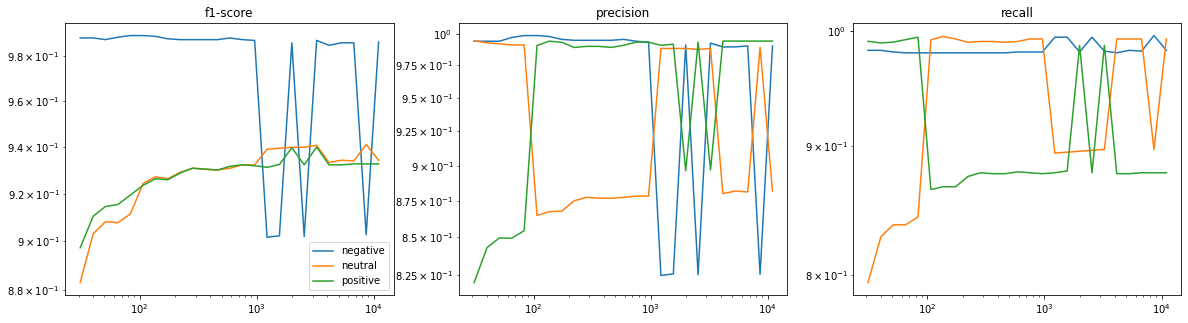

DecisionTreeClassifier:


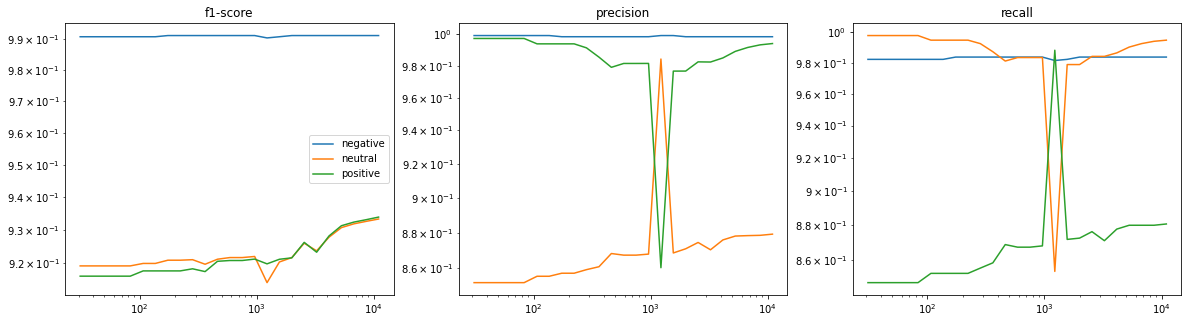

SVC kernel rbf:


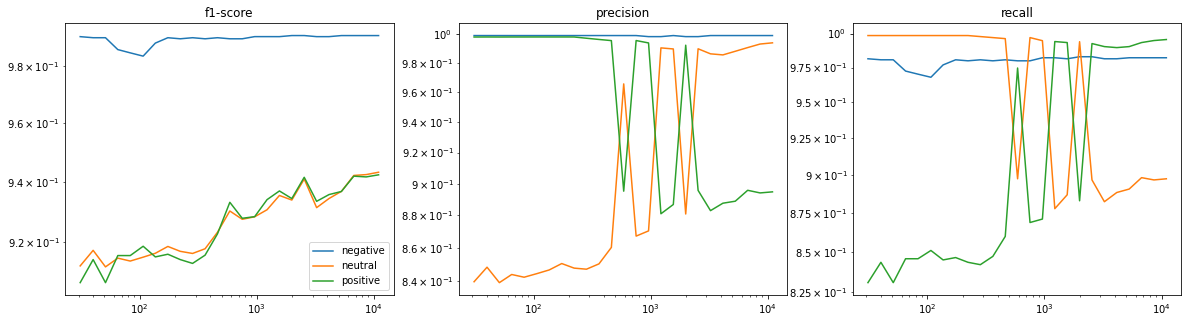

MLPClassifier 1 couche cachée:


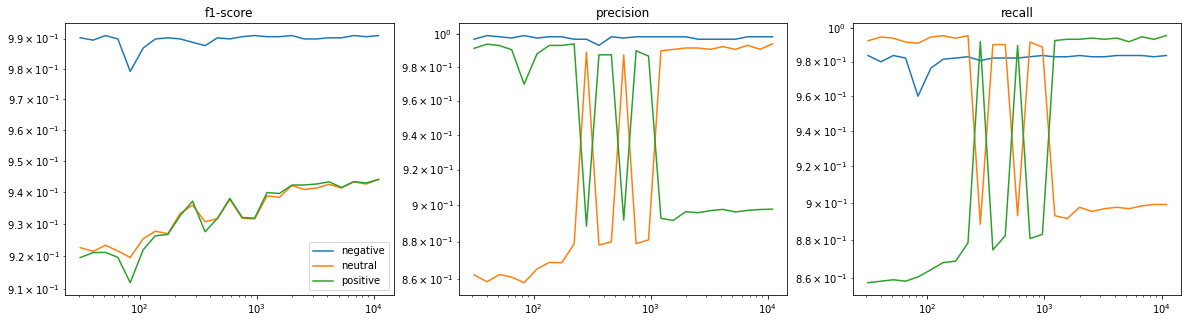

MLPClassifier 2 couches cachées:


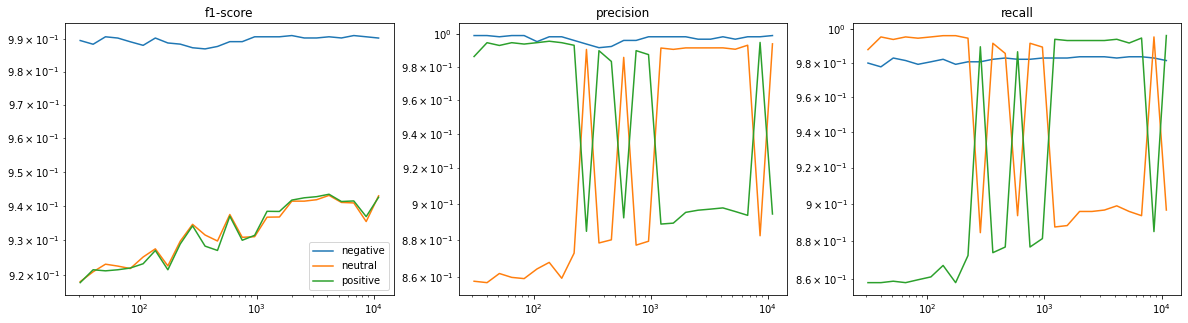

MLPClassifier 3 couches cachées:


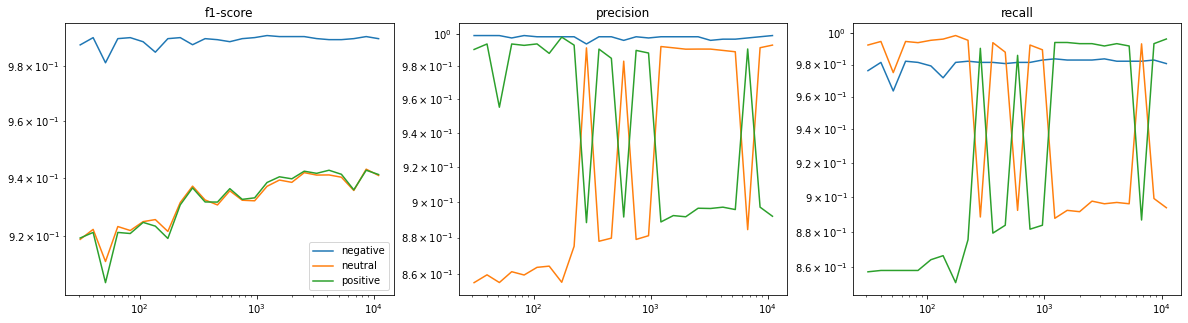

MLPClassifier 4 couches cachées:


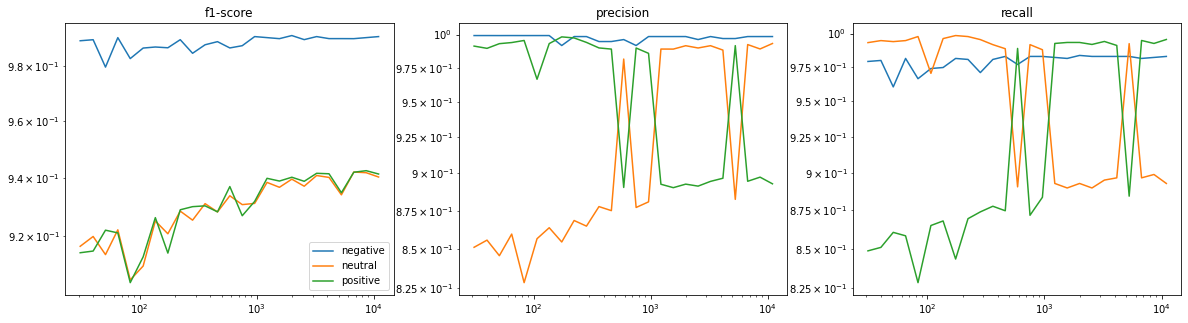

MLPClassifier 5 couches cachées:


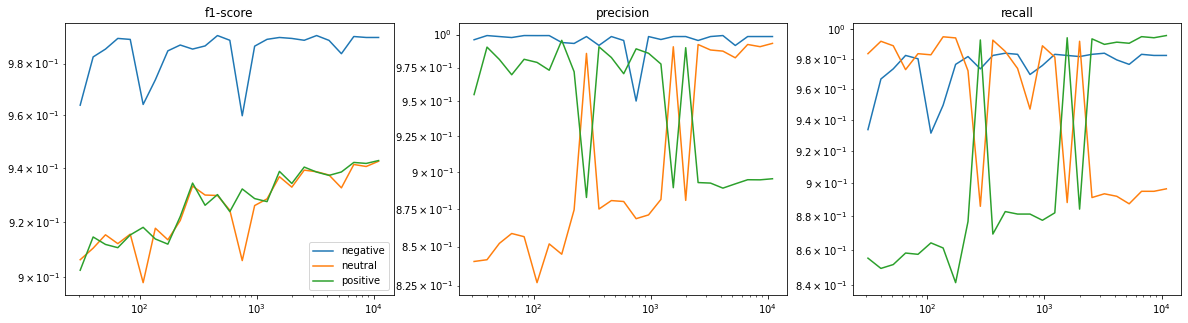

In [ ]:
CL = [NaiveBayesClassifier,
      DecisionTreeClassifier,
      SklearnClassifier( SVC(), sparse=False),
      SklearnClassifier( MLPClassifier(hidden_layer_sizes=(10),max_iter=5000), sparse=False),
      SklearnClassifier( MLPClassifier(hidden_layer_sizes=(10,10),max_iter=5000), sparse=False),
      SklearnClassifier( MLPClassifier(hidden_layer_sizes=(10,10,10),max_iter=5000), sparse=False),
      SklearnClassifier( MLPClassifier(hidden_layer_sizes=(10,10,10,10),max_iter=5000), sparse=False),
      SklearnClassifier( MLPClassifier(hidden_layer_sizes=(10,10,10,10,10),max_iter=5000), sparse=False),]

NCL = ['NaiveBayesClassifier',
       'DecisionTreeClassifier',
       'SVC kernel rbf',
       'MLPClassifier 1 couche cachée',
       'MLPClassifier 2 couches cachées',
       'MLPClassifier 3 couches cachées',
       'MLPClassifier 4 couches cachées',
       'MLPClassifier 5 couches cachées',]

test_data = reduce_dataset[11000:]
x_test=[]
y_test=[]
for a in test_data :
    x_test.append(a[0])
    y_test.append(a[1])

for i in range(len(NCL)):

    clf = CL[i]
    name = NCL[i]

    F0=[]
    P0=[]
    R0=[]

    F1=[]
    P1=[]
    R1=[]

    F2=[]
    P2=[]
    R2=[]

    K = np.int_(10**np.linspace(1.5,np.log10(11000-1),25))
    for k in K :
        train_data = reduce_dataset[:k]
        
        clf_sentiment = clf.train(train_data)
        
        y_pred = clf_sentiment.classify_many(x_test)

        d = metrics.classification_report(y_test,y_pred,output_dict=True )

        F0.append( d['Negative']['f1-score'] )
        P0.append( d['Negative']['precision'] )
        R0.append( d['Negative']['recall'] )
      
        F1.append( d['Neutral']['f1-score'] )
        P1.append( d['Neutral']['precision'] )
        R1.append( d['Neutral']['recall'] )

        F2.append( d['Positive']['f1-score'] )
        P2.append( d['Positive']['precision'] )
        R2.append( d['Positive']['recall'] )
    
    print(name+':')
    plt.figure(figsize = (20,5))

    plt.subplot(131)
    plt.loglog(K,F0,label = 'negative')
    plt.loglog(K,F1,label = 'neutral')
    plt.loglog(K,F2,label = 'positive')
    plt.title('f1-score')
    plt.legend()

    plt.subplot(132)
    plt.loglog(K,P0,label = 'negative')
    plt.loglog(K,P1,label = 'neutral')
    plt.loglog(K,P2,label = 'positive')
    plt.title('precision')

    plt.subplot(133)
    plt.loglog(K,R0,label = 'negative')
    plt.loglog(K,R1,label = 'neutral')
    plt.loglog(K,R2,label = 'positive')
    plt.title('recall')

    plt.show()

En premier lieu nous remarquons que les performances, bien que réduite restent correcte pour le classifieur de Bayes naïf.

Ensuite on remarquera que les performances des autres classifieurs n'atteignent pas encore de plateau contrairement au premier, on pourrait s'attendre des performances plus importantes avec un dataset plus grand. Enfin notre manière de sélectionner nos features est assez simple, on réduit notre vocabulaire à un certain nombre de mots donné, et les problèmes énoncés précédemment sont conservés, nous étudierons donc un peu plus le sujet dans le notebook reduction.ipynb .

##Documentation Utilisée

* documentation de nltk : https://www.nltk.org/index.html
* documentation scikitlearn : https://scikit-learn.org/stable/index.html
* https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk
